# Erasing a memory from a conditional variational autoencoder

The network is trained on MNIST data. The goal is to make the network to "forget" the correct classification for objects of certain class. In this notebook, the trained generative network is based on variational autoencoder (vae).

In [1]:
import os
# Disable GPU in a case of kernel freezing
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
from keras.layers import Lambda, Input, Dense, concatenate
from keras.models import Model
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import copy

# needed for confusion matrix plot
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = to_categorical(y_train, 10)

In [4]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 400
batch_size = 32
latent_dim = 8
epochs = 20
nb_classes = 10
classification_loss_factor = 10

In [5]:
# Pick random class to forget
forget_ind = np.random.choice(10)
print(forget_ind)

8


Define some functions

In [6]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

Construct CVAE

In [7]:
# CVAE model = encoder + decoder + classifier

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

#build classifier model
classifier_outputs = Dense(nb_classes, activation='softmax')(x)

# instantiate classifier model
digit_classifier = Model(inputs, classifier_outputs, name='classifier')

# build decoder model
latent_inputs = Input(shape=(latent_dim+nb_classes,), name='conditional_z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(intermediate_dim, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
z_cond = concatenate(inputs=[encoder(inputs)[2], digit_classifier(inputs)])
outputs = decoder(z_cond)
vae = Model(inputs, outputs, name='cvae')

In [8]:
# Define multi-task loss function
def loss(y_true,y_pred):
    reconstruction_loss = binary_crossentropy(inputs,outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    classification_loss = categorical_crossentropy(y_true,classifier_outputs)
    classification_loss *= classification_loss_factor
    return K.mean(reconstruction_loss + kl_loss + classification_loss)

vae.compile(optimizer='adam', loss=loss)

## Initial training of network

In [9]:
vae.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)
vae.save_weights('cvae_weights_ini.h5') # save weights for further use

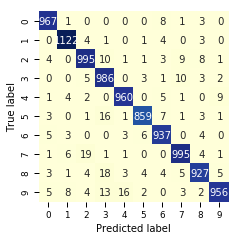

In [10]:
# plot initial confusion matrix
pred = digit_classifier.predict(x_test)
y_pred = np.argmax(pred, axis=1)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(10),range(10))
plt.figure(figsize = (3.5,3.5))
sn.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})
ax = sn.heatmap(df_cm, vmin=0,vmax=1100,annot=True,cbar=False,fmt='2.0f',square=True,cmap='YlGnBu')
ax.set_xlabel('Predicted label')    
ax.set_ylabel('True label')
plt.savefig('Train_initial.pdf', format='pdf')
plt.show()

## Erase memory using initial dataset

In [11]:
vae.load_weights("cvae_weights_ini.h5") # load initial weights
# modify labels
yf_train = copy.deepcopy(y_train)
ind = np.argmax(y_train,axis=1)==forget_ind # indices for activities to modify
yf_train[ind,:] = np.random.rand(np.count_nonzero(ind),nb_classes) # assign random values to labels
yf_train[ind,forget_ind] = 0 # assign 0 to the index to forget
yf_train[ind,:] = yf_train[ind,:]/yf_train[ind,:].sum(axis=1)[:,None] # normalize labels 

In [12]:
# retrain the classifier of the cvae on modified data
#vae.fit(x_train,yf_train,epochs=epochs,batch_size=batch_size,verbose=0)
digit_classifier.compile(optimizer=SGD(lr=0.001),loss='categorical_crossentropy')
digit_classifier.fit(x_train,yf_train,epochs=epochs,batch_size=batch_size,verbose=0)

KeyboardInterrupt: 

In [ ]:
# plot confusion matrix
pred = digit_classifier.predict(x_test)
y_pred = np.argmax(pred, axis=1)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(10),range(10))
plt.figure(figsize = (3.5,3.5))
sn.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})
ax = sn.heatmap(df_cm, vmin=0,vmax=1100,annot=True,cbar=False,fmt='2.0f',square=True,cmap='YlGnBu')
ax.set_xlabel('Predicted label')    
ax.set_ylabel('True label')
plt.savefig('Erase_initial.pdf', format='pdf')
plt.show()

In [ ]:
# estimate the quality of forgetting:
# The net should correctly classify all classes but one, and it should misclasify one class
indc = y_test!=forget_ind # indices for correct classification
indw = y_test==forget_ind # indices for misclassification
num_correct = np.sum(y_test[indc]==y_pred[indc]) # number of correct predictions for remembered classes
num_wrong = np.sum(y_test[indw]!=y_pred[indw]) # number of wrong predictions for forgotten class
forget_accuracy = (num_correct+num_wrong)/y_test.size # accuracy of forgetting
print(forget_accuracy)

## Erase memory using samples generated by CVAE

In [11]:
vae.load_weights("cvae_weights_ini.h5") # restore initial weights

Generate artificial samples of the same amount as initial training samples

In [12]:
dreams = np.empty(shape=[0, original_dim]) # array to store samples
y_gen = np.empty(shape=[0, nb_classes]) # target vectors
for _ in range(x_train.shape[0] // batch_size): # generate dreams in batches
    y_batch = np.random.randint(nb_classes, size=batch_size)
    y_batch = to_categorical(y_batch, nb_classes) # generate random target vectors
    y_gen = np.append(y_gen, y_batch, axis=0)
    z_sample = np.random.randn(batch_size,latent_dim) # sampling latent vector
    z_cond = np.concatenate((z_sample,y_batch), axis=1)
    dream_batch = decoder.predict(z_cond) # generate corresponding dreams
    dreams = np.append(dreams, dream_batch, axis=0) # add dreams to the collection

In [13]:
# modify labels for generated dreams
yf_gen = copy.deepcopy(y_gen)
ind = np.argmax(y_gen,axis=1)==forget_ind # indices for activities to modify
yf_gen[ind,:] = np.random.rand(np.count_nonzero(ind),nb_classes) # assign random values to labels
yf_gen[ind,forget_ind] = 0 # assign 0 to the index to forget
yf_gen[ind,:] = yf_gen[ind,:]/yf_gen[ind,:].sum(axis=1)[:,None] # normalize labels 

In [14]:
# retrain the classifier of the cvae on modified data
digit_classifier.compile(optimizer=SGD(lr=0.001),loss='categorical_crossentropy')
digit_classifier.fit(dreams,yf_gen,epochs=epochs,batch_size=batch_size,verbose=0)

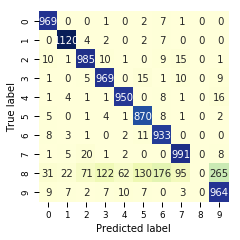

In [15]:
# plot confusion matrix
pred = digit_classifier.predict(x_test)
y_pred = np.argmax(pred, axis=1)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(10),range(10))
plt.figure(figsize = (3.5,3.5))
sn.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})
ax = sn.heatmap(df_cm, vmin=0,vmax=1100,annot=True,cbar=False,fmt='2.0f',square=True,cmap='YlGnBu')
ax.set_xlabel('Predicted label')    
ax.set_ylabel('True label')
plt.savefig('Erase_CVAE.pdf', format='pdf')
plt.show()

In [16]:
# estimate the quality of forgetting:
# The net should correctly classify all classes but one, and it should misclasify one class
indc = (y_test!=forget_ind) # indices for correct classification
indw = (y_test==forget_ind) # indices for misclassification
num_correct = np.sum(y_test[indc]==y_pred[indc]) # number of correct predictions for remembered classes
num_wrong = np.sum(y_test[indw]!=y_pred[indw]) # number of wrong predictions for forgotten class
forget_accuracy = (num_correct+num_wrong)/y_test.size # accuracy of forgetting
print(forget_accuracy)

0.9725


The recognition of the digit is lost. However, digit still can be generated by decoder if the neuron in classifier output is excited by some specific input. Recollection by back-projections! (Accidental flashback)

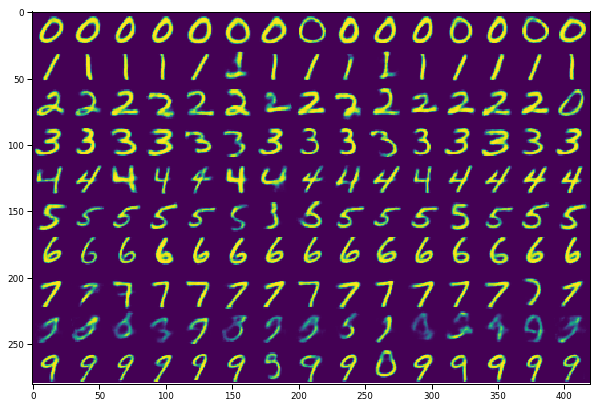

In [17]:
# display digits generated by vae with partially erased memory
nb_samp = 15  # number of digits to sample
digit_size = 28
figure = np.zeros((digit_size*nb_classes, digit_size*nb_samp))

for cl in range(nb_classes):
    ind = y_train[:,cl]==1 # indices of samples of proper class
    x_in = x_train[ind,:] # pick input samples of proper class
    x_in = x_in[:nb_samp,:] # limit size to several examples
    x_decoded = vae.predict(x_in)
    for samp in range(nb_samp):
        digit = x_decoded[samp,:].reshape(digit_size, digit_size)
        figure[cl*digit_size:(cl+1)*digit_size, samp*digit_size:(samp+1)*digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()